# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

!cp ../input/mia-v2 mia_v2 -r
from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
def f_target(X_train, y_train, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-3, patience=3)
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_split=0.2,
                      callbacks=[es]
                      )
  return model, history

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images/255
test_images = test_images/255

170508288/170498071 [==============================] - 14s 0us/step


In [4]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [5]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 20
D_SHADOW= attacker_images.shape[0]//N_SHADOWS

In [6]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [7]:
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack()

2022-04-09 16:59:44.955282: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-09 16:59:46.306850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
6/6 [==============================] - 1s 97ms/step - loss: 2.6493 - accuracy: 0.1254 - val_loss: 2.4313 - val_accuracy: 0.1758
Epoch 2/50
6/6 [==============================] - 0s 46ms/step - loss: 2.1980 - accuracy: 0.2209 - val_loss: 2.0859 - val_accuracy: 0.3152
Epoch 3/50
6/6 [==============================] - 0s 47ms/step - loss: 1.8780 - accuracy: 0.3463 - val_loss: 2.0092 - val_accuracy: 0.3333
Epoch 4/50
6/6 [==============================] - 0s 47ms/step - loss: 1.5969 - accuracy: 0.4657 - val_loss: 1.8961 - val_accuracy: 0.3394
Epoch 5/50
6/6 [==============================] - 0s 44ms/step - loss: 1.4392 - accuracy: 0.5582 - val_loss: 1.8651 - val_accuracy: 0.3091
Epoch 6/50
6/6 [==============================] - 0s 42ms/step - loss: 1.1842 - accuracy: 0.6388 - val_loss: 1.9586 - val_accuracy: 0.3152
Epoch 7/50
6/6 [==============================] - 0s 42ms/step - loss: 1.0774 - accuracy: 0.6716 - val_loss: 1.8821 - val_accuracy: 0.3091
Epoch 8/50
6/6 [===========

Epoch 1/100
1250/1250 [==============================] - 31s 24ms/step - loss: 1.4648 - accuracy: 0.4833 - val_loss: 1.2310 - val_accuracy: 0.5698
Epoch 2/100
1250/1250 [==============================] - 28s 22ms/step - loss: 1.1087 - accuracy: 0.6152 - val_loss: 1.1402 - val_accuracy: 0.6137
Epoch 3/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.9372 - accuracy: 0.6753 - val_loss: 1.0731 - val_accuracy: 0.6361
Epoch 4/100
1250/1250 [==============================] - 27s 21ms/step - loss: 0.7967 - accuracy: 0.7275 - val_loss: 1.0712 - val_accuracy: 0.6415
Epoch 5/100
1250/1250 [==============================] - 27s 22ms/step - loss: 0.6560 - accuracy: 0.7710 - val_loss: 1.1334 - val_accuracy: 0.6410
Epoch 6/100
1250/1250 [==============================] - 27s 22ms/step - loss: 0.5217 - accuracy: 0.8190 - val_loss: 1.1971 - val_accuracy: 0.6422
Epoch 7/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.4088 - accuracy: 0.8594 - val_loss: 1

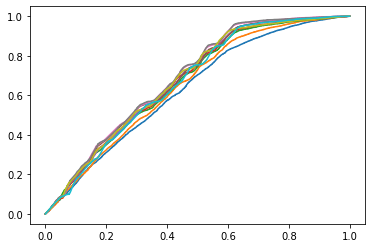

In [8]:
attacks = 10
scores = []
model_vuln = []
history = []
target_model = None
d_epochs = 2

# train once to get the best model, then train 2 epochs a time to overfit. Attack each time

for attack_i in range(attacks):
  if target_model is None:
    target_model, h = f_target(train_images, train_labels, epochs=100)
  else:
    h = target_model.fit(train_images, train_labels, epochs=d_epochs, validation_split=0.2)
  
  history.append(h)
  attack.target_model = target_model
  attack.target_dataset = train_images, train_labels
  _score = attack.evaluate_attack()
  scores.append(_score)

  model_vuln.append(evaluate_model_vulnerability(target_model, (train_images, train_labels), (attacker_images, attacker_labels), 'tf', batch_size=256))




In [9]:
epochs = d_epochs*np.arange(attacks+1)[1:]


Text(0, 0.5, 'Model Vulnerability')

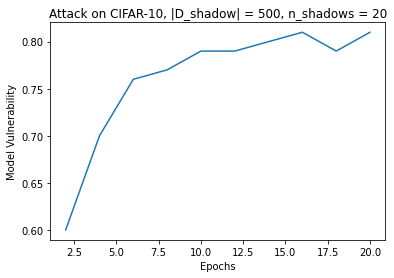

In [10]:
plt.plot(epochs, model_vuln)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('Model Vulnerability')

Text(0, 0.5, 'AUC Score')

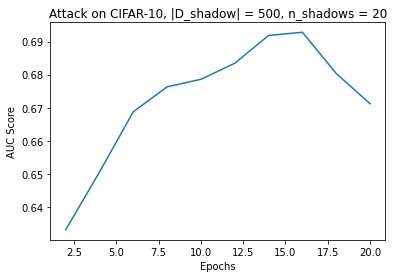

In [11]:
auc_scores = [items[1] for items in scores]

plt.plot(epochs, auc_scores)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

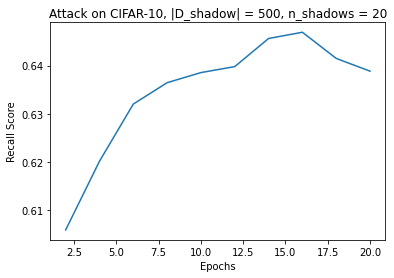

In [12]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(epochs, recall_scores)
plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

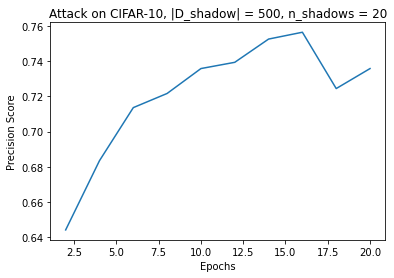

In [13]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(epochs, precision_scores)

plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

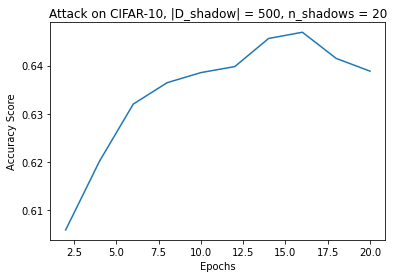

In [14]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(epochs, accuracy_scores)

plt.title(f'Attack on CIFAR-10, |D_shadow| = {D_SHADOW}, n_shadows = {N_SHADOWS}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')

Concat all the histories from model training.

In [15]:
loss = [item for h in history for item in h.history['loss']]
val_loss = [item for h in history for item in h.history['val_loss']]
epochs = np.arange(len(loss)+1)[1:]

acc = [item for h in history for item in h.history['accuracy']]
val_acc = [item for h in history for item in h.history['val_accuracy']]


Text(0.5, 1.0, 'Target model- CIFAR-10 - Training Curve - Loss')

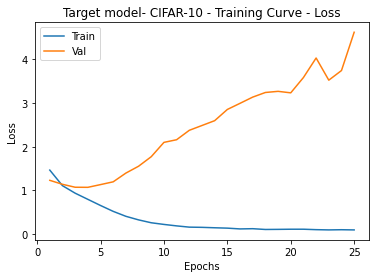

In [16]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["Train", "Val"])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Target model- CIFAR-10 - Training Curve - Loss')

Text(0.5, 1.0, 'Target model- CIFAR-10 - Training Curve - Accuracy')

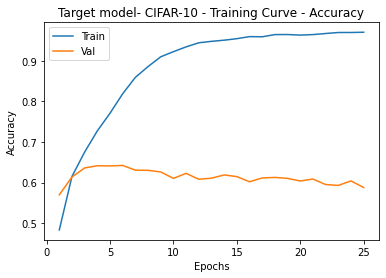

In [17]:
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Train", "Val"])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Target model- CIFAR-10 - Training Curve - Accuracy')